# The Khan and Thomas Model in Continuous Time
*Final Project for Computational Economics*

**Victoria Gregory, June 2016**

____

This notebook contains code for replicating the [Khan and Thomas (2008)](http://www.aubhik-khan.net/ecta5894.pdf) model in Julia and is part of my final project for [John Stachurski's computational economics course](https://github.com/jstac/quantecon_nyu_2016). A continuous time solution method is used, based on techniques developed by [Achdou, Han, Lasry, Lions, and Moll (2015)](http://www.princeton.edu/~moll/HACT.pdf) and [Ahn, Kaplan, Moll, and Winberry (2016)](http://www.princeton.edu/~moll/phactSlides.pdf). All code is adapted from the Matlab files available [here](http://www.princeton.edu/~moll/PHACTproject.htm). For additional details on the model or solution method, please refer to the papers above or [my accompanying document](https://github.com/vgregory757/KhanThomas/blob/master/Gregory_Project.pdf).

___

## Steady State

The first part of this notebook will go through the computation of the steady state of the model (i.e., with the aggregate TFP shocks shut down). The steady state solution is needed for the perturbation method used to solve for the aggregate dynamics.

I first define two types that are useful for storing information relevant to the model and its steady state solution.
* `KTModel`: Contains economic parameters, state space grids, and all other settings used for solving for the steady state
* `KTss`: This will contain all the steady state objects of the model solution. It will be useful later in the code when we want to refer to them when computing the aggregate dynamics.

In [18]:
#---------------------------------------------
# Define model type containing all parameters
#---------------------------------------------

type KTModel
  # Economic parameters:
  σ::Float64    # risk aversion coefficient
  ρ::Float64    # discount rate
  ϕ::Float64    # Frisch elasticity
  Θ::Float64    # capital coefficient
  ν::Float64    # labor coefficient
  δ::Float64    # depreciation rate
  χ0::Float64   # capital adj. costs
  χ1::Float64
  σTFP::Float64 # std. dev of TFP shocks
  ρTFP::Float64 # autocorr. of TFP shocks

  # Approximation parameters:
  nE::Int64              # grid sizes
  nK::Int64

  ϵ::Vector{Float64}     # productivity shocks
  ee::Matrix{Float64}
  eee::Vector{Float64}
  λ1::Float64
  λ2::Float64
  llaE::Vector{Float64}
  eAvg::Float64

  kmin::Float64         # capital grid
  kmax::Float64
  k::Vector{Float64}
  kk::Matrix{Float64}
  kkk::Vector{Float64}
  dk::Float64

  mLamF::SparseMatrixCSC{Float64,Int64}  # useful for computations later

  wmin::Float64           # for steady state computations
  wmax::Float64
  w0::Float64
  crit::Float64
  Δ::Float64
  maxit::Int64

  nVars::Int64           # Number of endogenous variables
  nEErrors::Int64
end

#---------------------------------------------------
# Define type for steady state solution of the model
#---------------------------------------------------
type KTss
  w::Float64
  output::Float64
  sdf::Float64
  v::Matrix{Float64}
  g::Matrix{Float64}
  If::BitArray
  Ib::BitArray
  I0::Matrix{Int64}
  investment::Matrix{Float64}
  vars::Vector{Float64}
end

The following function sets up a `KTModel` type based on user-chosen parameters (allows for default values, given below). It sets up the grids for idiosyncratic productivity and capital with two different arrangements, the minimum and maximum values for bisection over the wage, and a matrix that will be used in constructing the intensity matrix $\mathbf{A}$ later on. All grids are centered around representative-agent steady state values, in which everyone has the average of the productivity levels. It outputs everything into a `KTModel` type.

In [19]:
#---------------------------------------------------
# Function that sets up the Khan/Thomas model
#---------------------------------------------------

function KTModel(;σ::Float64=2.0,
  ρ::Float64=0.01,
  ϕ::Float64=0.5,
  Θ::Float64=0.21,
  ν::Float64=0.64,
  δ::Float64=0.025,
  χ0::Float64=0.001,
  χ1::Float64=2.0,
  σTFP::Float64=0.007,
  ρTFP::Float64=0.95,
  nE::Int64=2,
  nK::Int64=100,
  ϵ::Vector{Float64}=[0.9, 1.1],
  λ1::Float64=0.25,
  λ2::Float64=0.25,
  crit::Float64=1e-6,
  Δ::Float64=1.0e4,
  maxit::Int64=100)

  # set up space for idiosyncratic productivity shocks
  ee = ones(nK,1)*ϵ'
  eee = vec(reshape(ee,nE*nK,1))
  llaE = vec([λ1, λ2])
  eAvg = (llaE[1]*ϵ[2] + llaE[2]*ϵ[1])/(llaE[1] + llaE[2])

  # solve for representative agent steady state
  kRepSS = ((eAvg * Θ * ((1/3)) ^ ν) / (ρ + δ)) ^ (1 / (1 - Θ));
  wRepSS = eAvg * (kRepSS ^ Θ) * ν * ((1/3)) ^ (ν - 1);
  yRepSS = eAvg * (kRepSS ^ Θ) * (((1/3)) ^ ν)

  # set-up the capital grid
  kmin = 0.8*kRepSS
  kmax = 1.2*kRepSS
  k = linspace(kmin, kmax, nK)
  k = collect(k)
  kk = k*ones(1,nE)
  kkk = vec(reshape(kk,nE*nK,1))
  dk = (kmax - kmin)/(nK-1)

  # for computation
  mLamF = [-speye(nK) * llaE[1] speye(nK) * llaE[1]; speye(nK) * llaE[2] -speye(nK) * llaE[2]];

  # steady state computations
  wmin = 0.8*wRepSS
  wmax = 1.2*wRepSS
  w0 = wRepSS

  # number of endogenous variables
  nVars = 2*nE*nK-1+2
  nEErrors = nE*nK

  # put everything into a KTModel type
  KTModel(σ, ρ, ϕ, Θ, ν, δ, χ0, χ1, σTFP, ρTFP, nE, nK, ϵ,
  ee, eee, λ1, λ2, llaE, eAvg, kmin, kmax, k, kk, kkk, dk,
  mLamF, wmin, wmax, w0, crit, Δ, maxit, nVars, nEErrors)
end

KTModel

Next, I define a few functions that perform some widely used calculations in the solution method.
* a firm's individual labor demand (`labor_demand`) (from its FOC with respect to labor): $n_{ij} = \left(\frac{\varepsilon_i k_j ^ {\theta} \nu}{w} \right)^{\frac{1}{1-\nu}}$
* implication of the envelope condition (`envelope`): $\partial_k v(k) = \partial_i \pi(i) = 1 + \frac{\chi_1 i}{k}$
* drift of capital (`kdot`): $\dot{k} = i - \delta k$
* optimal investment (`ipol`):
    conditional on investing, the firm solves
    $$\max_i \left( v' i - \left[i + \chi_0 + \frac{\chi_1}{2} \left(\frac{i}{k} \right)^2 k\right] \right)$$
    which leads to solution: $i = \frac{k}{\chi_1}(v' - 1)$ Invest if the value of investing is positive; if not, investment is 0.

In [20]:
# individual labor function (from FOC)
function labor_demand(eg::KTModel, w::Float64, k::Matrix{Float64}, ϵ::Matrix{Float64})
  n_i = (w ./ (ϵ .* k .^eg.Θ .* eg.ν)) .^ (1 / (eg.ν - 1))
  return n_i
end

# envelope condition: π' = v'
function envelope(eg::KTModel, k::Matrix{Float64}, i::Matrix{Float64})
  env = 1 + (eg.χ1 .* i)./k
  return env
end

# drift of capital
function kdot(eg::KTModel, k::Matrix{Float64}, i::Matrix{Float64})
  kd = i - eg.δ .* k
  return kd
end

# optimal investment, given value function and capital
function ipol(eg::KTModel, dV::Matrix{Float64}, k::Matrix{Float64})
  i = (k./eg.χ1) .* (dV - 1)
  opt_i = i .* (dV.*i - (i + eg.χ0 + (eg.χ1/2).*((i./k).^2) .* k) .>= 0)
  netInv = kdot(eg, eg.kk, opt_i)
  return opt_i, netInv
end

ipol (generic function with 1 method)

The next function does all the work in computing the steady state. The outer loop iterates over the wage guess. The inner loop computes the value function using the implicit scheme. Upon convergence, it computes the stationary distribution from the Kolmogorov-Forward equation. After that, it computes excess labor supply by aggregating up the individual labor policy functions and updates the wage guess accordingly. Once the wage has converged, it computes steady state aggregate consumption, output, and the sdf and returns it all as a `KTss` type.

In [21]:
#-------------------------------------------------
# Function to compute the steady state
# (no aggregate shocks case)
#-------------------------------------------------

function steady_state(eg::KTModel)

  # initialize first wage guess
  w = eg.w0

  dVf = zeros(eg.nK, eg.nE)
  dVb = zeros(eg.nK, eg.nE)

  # stuff we'll need to access outside the inner for loop
  A = spzeros(eg.nK*2, eg.nK*2)
  V = zeros(eg.nK, eg.nE)
  v = zeros(eg.nK, eg.nE)
  g = zeros(eg.nK, eg.nE)
  investment = zeros(eg.nK, eg.nE)
  If = (investment .> 0)
  Ib = (investment .> 0)
  I0 = (investment .> 0)

  for i = 1:eg.maxit

      # labor demand
      vLaborDemand = labor_demand(eg, w, eg.kk, eg.ee)

      # guess for value function
      v0 = (eg.ee .* (eg.kk .^ eg.Θ) .* (vLaborDemand .^ eg.ν) - w * vLaborDemand - eg.δ * eg.kk - eg.χ0 - (eg.χ1/2) * (eg.δ ^ 2))/eg.ρ

      # if not the first wage guess, use the value function from last time
      if i > 1
        v0 = V
      end
      v = v0

      # solve for the value function given w

      for n = 1:eg.maxit

        V = v;

        # compute forward difference
        dVf[1:eg.nK-1, :] = (V[2:eg.nK, :] - V[1:eg.nK-1, :]) / eg.dk
        dVf[eg.nK, :] = envelope(eg, eg.kk[end,:], eg.kk[end,:].*eg.δ)

        # compute backward difference
        dVb[2:eg.nK, :] = (V[2:eg.nK, :] - V[1:eg.nK-1, :]) / eg.dk
        dVb[1, :] = envelope(eg, eg.kk[1,:], eg.kk[1,:].*eg.δ)

        # compute investment and drift with forward difference
        invF, netInvF = ipol(eg, dVf, eg.kk)

        # compute investment and drift with backward difference
        invB, netInvB = ipol(eg, dVb, eg.kk)

        # derivative of value function with no drift
        dV0 = envelope(eg, ones(eg.nK, eg.nE), ones(eg.nK, eg.nE).*eg.δ)

        # upwind method
        If = (netInvF .> 1e-20)
        Ib = (netInvB .< 1e-20)
        I0 = (1 - If - Ib)
        dV_Upwind = dVf.*If + dVb.*Ib + dV0.*I0

        # compute investment from upwind method
        investment, netInv = ipol(eg, dV_Upwind, eg.kk)
        u = eg.ee .* (eg.kk .^ eg.Θ) .* (vLaborDemand .^ eg.ν) - w * vLaborDemand  - investment - eg.χ0 * (abs(investment) .> 1e-8) - (eg.χ1 / 2) * ((investment ./ eg.kk) .^ 2) .* eg.kk

        # matrices for implicit scheme
        X = -min(netInvB, 0) ./ eg.dk
        Y = -max(netInvF, 0) ./ eg.dk + min(netInvB, 0) ./ eg.dk
        Z = max(netInvF, 0) ./ eg.dk

        A1 = spdiagm(Y[:,1], 0, eg.nK, eg.nK) + spdiagm(X[2:eg.nK,1], -1, eg.nK, eg.nK) + spdiagm(Z[1:eg.nK-1,1], 1, eg.nK, eg.nK)
        A2 = spdiagm(Y[:,2], 0, eg.nK, eg.nK) + spdiagm(X[2:eg.nK,2], -1, eg.nK, eg.nK) + spdiagm(Z[1:eg.nK-1,2], 1, eg.nK, eg.nK)
        A = [A1 spzeros(eg.nK, eg.nK); spzeros(eg.nK,eg.nK) A2] + eg.mLamF

        B = (1/eg.Δ + eg.ρ)*speye(2*eg.nK) - A

        u_stacked = reshape(u, eg.nE*eg.nK, 1)
        V_stacked = reshape(V, eg.nE*eg.nK, 1)
        b = u_stacked + V_stacked/eg.Δ

        # solve the system
        V_stacked = B\b

        V = reshape(V_stacked, eg.nK, eg.nE)

        # check for convergence
        Vchange = V - v
        v = V

        dist = maximum(maximum(abs(Vchange)))
        if dist < eg.crit
          @printf("Value function converged, iteration %d.\n", n)
          break
        end
      end

      ###
      # Solve KF equation for stationary distribution
      ###

      AT = A'
      b = zeros(2*eg.nK, 1)

      # pdf Normalization
      i_fix = 1
      b[i_fix] = 0.1
      row = [zeros(1, i_fix-1) 1 zeros(1, 2*eg.nK-i_fix)]
      AT[i_fix, :] = row

      # solve linear system
      gg = AT\b
      g_sum = gg'*ones(eg.nE*eg.nK, 1)*eg.dk
      gg = gg./g_sum
      g = reshape(gg, eg.nK, eg.nE)

      # compute excess labor supply
      S = (1/3) - sum(reshape(vLaborDemand, eg.nE*eg.nK, 1) .* gg * eg.dk)

      # update wage
      if S > eg.crit
        eg.wmax = w
        w = 0.5*(w + eg.wmin)

      elseif S < -eg.crit
        eg.wmin = w
        w = 0.5*(w + eg.wmax)

      elseif abs(S) < eg.crit
        @printf("Steady state wage found: %.3f.\n", w)

        # compute some aggregates
        χ = w / ((1/3) ^ eg.ϕ)
        vOutputGrid = eg.ee .*(eg.kk .^ eg.Θ) .* (vLaborDemand .^ eg.ν)
        vConsumptionGrid = vOutputGrid - investment - eg.χ0 * (abs(investment) .> 1e-8) - (eg.χ1/2) * ((investment ./ eg.kk) .^2) .* eg.kk
        output = sum(vOutputGrid[:] .* g[:] * eg.dk)
        consumption = sum(vConsumptionGrid[:] .* g[:] * eg.dk)
        sdf = (consumption - χ * ((1/3) ^ (1 + eg.ϕ)) / (1 + eg.ϕ)) .^ (-eg.σ)

        # combine steady state variables for input into equilibrium conditions function
        varsSS = zeros(eg.nVars, 1)
        varsSS[1:eg.nE*eg.nK, 1] = sdf * reshape(v, eg.nE*eg.nK, 1)
        ggSS = reshape(g, eg.nE*eg.nK, 1)
        varsSS[eg.nE*eg.nK+1:2*eg.nK*eg.nE-1, 1] = ggSS[1:eg.nE*eg.nK-1, 1]
        varsSS[2*eg.nE*eg.nK, 1] = sdf
        varsSS[2*eg.nE*eg.nK+1, 1] = 0

            return KTss(w, output, sdf, v, g, If, Ib, I0, investment, vec(varsSS))
        break
      end

  end

end

steady_state (generic function with 1 method)

Now I are ready to set up the model and compute its steady state. All that needs to be done is to create a `KTModel` with the default values and run `steady_state` on it.

In [22]:
eg = KTModel()
@time eg_ss = steady_state(eg);

Value function converged, iteration 16.
Value function converged, iteration 9.
Value function converged, iteration 7.
Value function converged, iteration 5.
Value function converged, iteration 5.
Value function converged, iteration 5.
Value function converged, iteration 4.
Value function converged, iteration 4.
Value function converged, iteration 4.
Value function converged, iteration 4.
Value function converged, iteration 3.
Value function converged, iteration 3.
Value function converged, iteration 3.
Value function converged, iteration 3.
Value function converged, iteration 3.
Value function converged, iteration 3.
Value function converged, iteration 3.
Steady state wage found: 1.273.
  0.341850 seconds (511.31 k allocations: 72.004 MB, 4.06% gc time)


___

## Aggregate Dynamics

With the steady state in hand, I am now ready to solve for the aggregate dynamics of the model. I will again define a new type and related function that will be useful for this part.
* `StateVec`: Contains all the variables that we want to treat as endogenous for `gensys`. Referred to as $\mathbf{y}(t) = (\mathbf{v}(t), \mathbf{g}(t), \Lambda(t), \log Z(t))'$ in the description of the solution method. There are no type declarations here, because the automatic differentiation routine will be sending dual numbers to the fields, whereas everywhere else the fields will be matrices or scalars. 

* `extract` accepts a vector input which contains, in order, the value function, distribution, SDF, and log TFP shock (i.e., everything that should be in $\mathbf{y}(t)$) and puts them into a `StateVec` type. This is useful because sometimes we'll want to use $\mathbf{y}(t)$ as a vector, like in simulation, and other times we'll just want easy access to its attributes.




In [23]:
#---------------------------------------------------
# Define type for the state vector
#---------------------------------------------------
type StateVec
  v
  g
  g_end
  sdf
  logAggregateTFP
end

#---------------------------------------------------
# Function that extracts the state from a Vector
#---------------------------------------------------
function extract(vars, eg::KTModel, eg_ss::KTss)

  V = vars[1:eg.nE*eg.nK, 1] + eg_ss.vars[1:eg.nE*eg.nK, 1]
  V = reshape(V, eg.nK, eg.nE)
  g = vars[eg.nE*eg.nK+1:2*eg.nE*eg.nK-1] + eg_ss.vars[eg.nE*eg.nK+1:2*eg.nE*eg.nK-1]
  g_end = 1 / eg.dk - sum(g)
  sdf = vars[2*eg.nE*eg.nK, 1] + eg_ss.vars[2*eg.nE*eg.nK, 1]
  logAggregateTFP = vars[2*eg.nE*eg.nK+1, 1]

  return StateVec(V, g, g_end, sdf, logAggregateTFP)

end

extract (generic function with 1 method)

Next I'll define a few more useful functions that will be needed for the residual function and for computing aggregate economic variables.
* analogue of individual labor demand equation with TFP shocks (`agg_labor`)
* analogue of investment policy with TFP shocks (`ipol_agg`)
* wage determination (`wage`). Comes from combining household and firm FOCs with respect to labor and solving out for the wage, which yields:
$$w = \left[(Z \nu)^{\varphi} \chi^{1-\nu} I ^{(1-\nu) \varphi} \right]^{\frac{1}{\varphi + 1 -\nu}}$$
where $I = \left[ \left(\mathbf{\varepsilon} \mathbf{k} ^{\theta} \right)^{\frac{1}{1-\nu}} \right]' \mathbf{g}$.

In [24]:
# labor demand for case with aggregate shocks
function agg_labor(eg::KTModel, state::StateVec, w, k, ϵ)
  vLaborDemand = ((eg.ν * exp(state.logAggregateTFP) * ϵ .* (k .^ eg.Θ)) * (w ^ (-1))) .^ (1 / (1 - eg.ν))
  vLaborDemand = reshape(vLaborDemand, eg.nK, eg.nE)
  return vLaborDemand
end

# optimal investment for case with aggregate shocks
function ipol_agg(eg::KTModel, state::StateVec, dV, k)
  inv = (k / eg.χ1) .* ((reshape(dV,eg.nE*eg.nK,1) * (state.sdf ^ (-1))) - 1)
  inv = inv .* (reshape(dV,eg.nE*eg.nK,1) .* inv - state.sdf * (inv + eg.χ0 + (eg.χ1 / 2) * ((inv ./ k) .^ 2) .* k) .>= 0)
  netInv = reshape(inv - eg.δ * k, eg.nK, eg.nE)
  return inv, netInv
end

# wage for case with aggregate shocks
function wage(eg::KTModel, eg_ss::KTss, state::StateVec, k, ϵ)
  vIntegrandGrid = (ϵ .* (k .^ eg.Θ)) .^ (1 / (1 - eg.ν))
  integral = sum(vIntegrandGrid[1:eg.nE*eg.nK-1] .* state.g * eg.dk) + state.g_end * eg.dk * vIntegrandGrid[eg.nE*eg.nK]
  χ = eg_ss.w / ((1/3) ^ eg.ϕ)
  w = ((χ ^ (1 - eg.ν)) * ((exp(state.logAggregateTFP) * eg.ν) ^ eg.ϕ) * (integral ^ (eg.ϕ * (1 - eg.ν)))) ^ (1 / (eg.ϕ + 1 - eg.ν))
  return w, χ
end

wage (generic function with 1 method)

Now, I write a function for computing the residual function:
$$
	\mathbf{F}(\mathbf{y}(t), \dot{\mathbf{y}}(t), \mathbf{z}(t), \mathbf{\eta}(t)) =
	\begin{bmatrix}
		\mathbf{\pi}(t) + \mathbf{A}(t) \mathbf{v}(t) + \dot{\mathbf{v}}(t) - \mathbf{\eta}_{\mathbf{v}}(t) - \rho \mathbf{v}(t) \\
		\mathbf{A}(t)^T \mathbf{g}(t) - \dot{\mathbf{g}}(t) \\
		\Lambda(t) - \left(C(t) - \chi \frac{N(t)^{1+\varphi}}{1+\varphi} \right)^{-\sigma} \\
		- (1 - \rho_z) \log Z(t) dt + \sigma_z \mathbf{z}(t) - \dot{\log Z}(t)
	\end{bmatrix}$$
    
Except here, the first input will actually be $\hat{\mathbf{y}}(t) = \mathbf{y}(t) - \mathbf{y}^*$, where $\mathbf{y}^*$ is the steady state solution to the model, so that feeding the function a vector of zeros will give its value at steady state. This function is designed with just one vector input and one vector output. That's because of restrictions on the types of functions that the automatic differentiation routine can work with. Notice that the `KTModel` and `KTss` types created before are still able to be passed through to the function.

In [25]:
#------------------------------------------------------
# Function to compute equilibrium conditions in gensys form
# -----------------------------------------------------

function equilibrium_conditions(vars::Vector)

  # unpack the input

  # everything in y
  state = extract(vars[1:eg.nVars], eg, eg_ss)

  # everything in ydot
  vDot = vars[eg.nVars+1:eg.nVars+eg.nE*eg.nK, 1]
  gDot = vars[eg.nVars+eg.nE*eg.nK+1:eg.nVars+2*eg.nE*eg.nK-1, 1]
  sdfDot = vars[eg.nVars+2*eg.nE*eg.nK, 1]
  logAggregateTFPDot = vars[eg.nVars+2*eg.nE*eg.nK+1, 1]

  # everything in η
  VEErrors = vars[2*eg.nVars+1:2*eg.nVars+eg.nE*eg.nK, 1]

  # everything in z
  aggregateTFPShock = vars[2*eg.nVars+eg.nEErrors+1, 1]

  dVf = zeros(state.v)
  dVb = zeros(state.v)

  # compute wage
  w, χ = wage(eg, eg_ss, state, eg.kkk, eg.eee)

  # firm HJB
  vLaborDemand = agg_labor(eg, state, w, eg.kkk, eg.eee)

  # forward difference
  dVf[1:eg.nK-1,:] = (state.v[2:eg.nK,:] - state.v[1:eg.nK-1,:]) / eg.dk
  dVf[eg.nK,:] = (state.sdf * (1 + eg.δ * eg.χ1)).*ones(1,eg.nE)

  # backward difference
  dVb[2:eg.nK,:] = (state.v[2:eg.nK,:] - state.v[1:eg.nK-1,:]) / eg.dk
  dVb[1,:] = (state.sdf * (1 + eg.δ * eg.χ1)).*ones(1,eg.nE)

  # investment policy with forward difference
  invF, netInvF = ipol_agg(eg, state, dVf, eg.kkk)

  # investment policy with backward difference
  invB, netInvB = ipol_agg(eg, state, dVb, eg.kkk)

  # derivative of value function with no drift
  dV0 = state.sdf * (1 + eg.δ * eg.χ1) * ones(eg.nK,eg.nE)

  # upwind method
  dV_Upwind = dVf .* eg_ss.If + dVb .* eg_ss.Ib + dV0 .* eg_ss.I0

  # investment using upwind method
  investment, netInv = ipol_agg(eg, state, dV_Upwind, eg.kkk)

  # profits
  u = state.sdf * (exp(state.logAggregateTFP) * eg.eee .* (eg.kkk .^ eg.Θ) .* (reshape(vLaborDemand,eg.nK*eg.nE,1) .^ eg.ν) - w * reshape(vLaborDemand,eg.nK*eg.nE,1) - investment - eg.χ0 * (abs(investment) .> 1e-8) - (eg.χ1 / 2) * ((investment ./ eg.kkk) .^ 2) .* eg.kkk)

  # construct A matrix
  X = -netInvB.*eg_ss.Ib/eg.dk
  Y = -netInvF.*eg_ss.If/eg.dk + netInvB.*eg_ss.Ib/eg.dk
  Z = netInvF.*eg_ss.If/eg.dk
  X[1,:]=0
  lowdiag = reshape(X,eg.nE*eg.nK,1)
  Z[eg.nK,:]=0
  updiag = reshape(Z,eg.nE*eg.nK,1)
  A = spdiagm(vec(reshape(Y,eg.nE*eg.nK,1)),0,eg.nE*eg.nK,eg.nE*eg.nK) + spdiagm(lowdiag[2:eg.nE*eg.nK],-1,eg.nE*eg.nK,eg.nE*eg.nK) + spdiagm(updiag[1:eg.nE*eg.nK-1],1,eg.nE*eg.nK,eg.nE*eg.nK) + eg.mLamF

  # equilibrium conditions

  # firm HJB
  hjbResidual = reshape(u,eg.nE*eg.nK,1) + A * reshape(state.v,eg.nE*eg.nK,1) + vDot - VEErrors - eg.ρ * reshape(state.v,eg.nE*eg.nK,1)

  # firm KFE
  gDotIntermediate = A' * [state.g; state.g_end]
  gResidual = gDot - gDotIntermediate[1:eg.nE*eg.nK-1,1]

  # sdf
  vConsumptionGrid = (exp(state.logAggregateTFP) * eg.eee .* (eg.kkk .^ eg.Θ) .* (reshape(vLaborDemand,eg.nK*eg.nE,1) .^ eg.ν)) - investment - eg.χ0 * (abs(investment) .> 1e-8) - (eg.χ1 / 2) * ((investment ./ eg.kkk) .^ 2) .* eg.kkk
  consumption = sum(vConsumptionGrid .* [state.g; state.g_end] * eg.dk)
  labor = (w / χ) ^ (1 / eg.ϕ)
  sdfResidual = (consumption - χ * ((labor ^ (1 + eg.ϕ)) / (1 + eg.ϕ))) ^ (-eg.σ) - state.sdf

  # aggregate shocks
  tfpResidual = logAggregateTFPDot + (1 - eg.ρTFP) * state.logAggregateTFP - eg.σTFP * aggregateTFPShock

  vResidual = [hjbResidual; gResidual; sdfResidual; tfpResidual]

  return vec(vResidual)

end


equilibrium_conditions (generic function with 1 method)

Now, we need to find the Jacobian of this function and evaluate it at the steady state (which is a vector of zeros here). For this, I use the package [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl).

In [26]:
using ForwardDiff

# compute Jacobian of equilibrium_conditions at steady state
ss = vec(zeros(2*eg.nVars + eg.nEErrors +1, 1))
@time derivs = ForwardDiff.jacobian(equilibrium_conditions, ss);

  0.352908 seconds (251.05 k allocations: 265.720 MB, 13.16% gc time)


The next step is to send these derivatives into `gensys`. We want to solve the model:

$$
	\mathbf{F}^*_1(\mathbf{y}(t) - \mathbf{y}^*) + \mathbf{F}_2^* \dot{\mathbf{y}}(t) + \mathbf{F}_3^* \mathbf{z}(t) + \mathbf{F}_4^* \mathbf{\eta}(t) \approx \mathbf{0}
$$

$\mathbf{F}^*_1, \mathbf{F}_2^*, \mathbf{F}_3^*$, and $\mathbf{F}_4^*$ are the partial derivative matrices of $\mathbf{F}$ evaluated at the steady state. This comes from a first-order Taylor expansion of the residual function about the steady state. `gensys` accepts inputs in the following format:
$$
\mathbf{\Gamma_0}\dot{\mathbf{y}}(t) = \mathbf{c} + \mathbf{\Gamma_1}\mathbf{y}(t) + \mathbf{\Psi}\mathbf{z}(t) + \mathbf{\Pi}\mathbf{\eta}(t)
$$
so in the next block of code, I unpack the derivative matrix and re-arrange for input into `gensys`.

In [27]:
# unpackage the partial derivatives
mVarsDerivs = derivs[:,1:eg.nVars];
mVarsDotDerivs = derivs[:,eg.nVars+1:2*eg.nVars]
mEErrorsDerivs = derivs[:,2*eg.nVars+1:2*eg.nVars+eg.nEErrors]
mShocksDerivs = derivs[:,2*eg.nVars+eg.nEErrors+1]

# re-arrange into gensys form
Γ0 = mVarsDotDerivs
Γ1 = -mVarsDerivs
c = spzeros(eg.nVars, 1)
Ψ = -mShocksDerivs
Π= -mEErrorsDerivs;

Below is my `gensys` function. It is based on [Chris Sims' algorithm](http://sims.princeton.edu/yftp/gensys/LINRE3A.pdf). It differs from other Julia implementations (like the [New York Fed's](https://github.com/FRBNY-DSGE/DSGE.jl/blob/master/src/solve/gensys.jl)) because it uses the continuous time version, in which the eigenvalues are ordered differently.

In [28]:
#---------------------------------------------------
# Implements gensys for a continuous time process
# Note: doesn't check for existence/uniqueness
#---------------------------------------------------

function gensys(Γ0, Γ1, c, Ψ, Π)

  # put into reduced form
  temp = (maximum(abs([Γ0 Ψ]), 2) .== 0)
  redundant = find(temp)
  base = nullspace(Γ1[redundant, :])

  Γ0 = base'*Γ0*base
  Γ1 = base'*Γ1*base
  Γ1 = Γ0\Γ1
  Ψ = Γ0\base'*Ψ
  Π = Γ0\base'*Π
  c = Γ0\base'*c

  # Schur factorization, re-order eigenvalues
  n = size(Γ1, 1)
  Γ1 = schurfact!(Γ1)
  select = real(Γ1[:values]) .< 0
  ordschur!(Γ1, select)
  nunstab = sum(select)
  U = Γ1[:vectors]
  T = Γ1[:Schur]

  # compute G1
  G1 = U*T*spdiagm(vec([ones(n-nunstab, 1); zeros(nunstab, 1)]), 0, n, n)*U'
  G1 = real(G1)
  G1 = base*G1*base'

  # compute impact
  u2=U[:,n-nunstab+1:n]'
  u1=U[:,1:n-nunstab]'

  etawt = u2*Π
  etawt_fac = svdfact!(etawt)
  ueta, deta, veta  = etawt_fac[:U], etawt_fac[:S], etawt_fac[:V]
  md = minimum(size(deta))
  realsmall = sqrt(eps())*10
  bigev = find((deta[1:md]) .> realsmall)
  ueta = ueta[:, bigev]
  veta = veta[:, bigev]
  deta = deta[bigev]

  zwt = u2*Ψ
  impact = real(-Π * veta * (diagm(deta)\ueta')*u2*Ψ + Ψ)
  impact = base*impact

  return G1, impact

end

gensys (generic function with 1 method)

Now we send the partial derivative matrices to `gensys`, and we have our solution!

In [29]:
# solve system using gensys
@time G1, impact = gensys(Γ0, Γ1, c, Ψ, Π);

  0.393255 seconds (19.21 k allocations: 47.755 MB, 1.43% gc time)


___

## Simulation

Here, I'll define a new type and new function useful for simulating the model. The type `Aggregates` will store all the aggregate variables of interest for a given point in the simulation. The corresponding function computes these, given the wage, investment, and labor policies, and outputs an `Aggregates` type.

In [30]:
#-------------------------------------------------
# Define type for aggregate variables for simulation
#-------------------------------------------------

type Aggregates

  Investment::Float64
  Capital::Float64
  Consumption::Float64
  Output::Float64
  Hours::Float64
  Wage::Float64
  SDF::Float64
  Dist1::Vector{Float64}
  Dist2::Vector{Float64}
  InvPol1::Vector{Float64}
  InvPol2::Vector{Float64}

end

#--------------------------------------------------
# Function that computes aggregate variables
#--------------------------------------------------

function Aggregates(eg::KTModel, eg_ss::KTss, state::StateVec, w::Float64, χ::Float64, vLaborDemand::Matrix{Float64}, investment::Matrix{Float64}, k, ϵ)

  Investment = sum(investment .* [state.g; state.g_end] * eg.dk)
  Capital = sum(k .* [state.g; state.g_end] * eg.dk)
  vConsumptionGrid = (exp(state.logAggregateTFP) * ϵ .* (k .^ eg.Θ) .* (reshape(vLaborDemand,eg.nK*eg.nE,1) .^ eg.ν)) - investment - eg.χ0 * (abs(investment) .> 1e-8) - (eg.χ1 / 2) * ((investment ./ k) .^ 2) .* k
  Consumption = sum(vConsumptionGrid .* [state.g; state.g_end] * eg.dk)
  vOutputGrid = (exp(state.logAggregateTFP) * ϵ .* (k .^ eg.Θ) .* (reshape(vLaborDemand,eg.nK*eg.nE,1) .^ eg.ν))
  Output = sum(vOutputGrid[:] .* [state.g; state.g_end] * eg.dk)
  Hours = (w / χ) ^ (1 / eg.ϕ)
  Wage = w
  SDF = state.sdf
  Dist1 = state.g[1:eg.nK]
  Dist2 = [state.g[eg.nK+1:2*eg.nK-1]; state.g_end]
  InvPol1 = investment[1:eg.nK]
  InvPol2 = investment[eg.nK+1:2*eg.nK]

  Aggregates(Investment, Capital, Consumption, Output, Hours, Wage, SDF, vec(Dist1), vec(Dist2), vec(InvPol1), vec(InvPol2))

end

Aggregates

To simulate the model, we just need to iterate on:
$$
\mathbf{y}(t + \Delta_t) \approx (\Delta_t \mathbf{G}_t + \mathbf{I}) \mathbf{y}(t) + \mathbf{\Theta} \sqrt{\Delta_t} \varepsilon (t)
$$
where $\Delta_t$ is a time step length. The function `simulate` does exactly that, then computes all the aggregates we may be interested in at each point in the simulation. It returns both the $\mathbf{y}(t)$ series (`state_series`) as an array of type `StateVec` as well as the series of aggregates (`agg_series`) as an array of type `Aggregates`.

In [31]:
function simulate(eg::KTModel, eg_ss::KTss, vAggregateShock, G1, impact, N, dt)

  # endogenous variables
  vVarsSeries = zeros(eg.nVars, N+1)

  # time series for aggregates
  agg_series = Array(Aggregates, N)

  # time series for endogenous state
  state_series = Array(StateVec, N+1)
  state_series[1] = extract(zeros(eg.nVars, 1), eg, eg_ss)

  # simulate
  for n = 1 : N

    # endogenous variables
    vVarsSeries[:, n+1] = (dt * G1 + speye(eg.nVars)) * vVarsSeries[:,n] + (dt ^ (1 / 2)) * impact * vAggregateShock[n,1]'

    # extract relevant objects
    vars = vVarsSeries[:, n+1]
    state = extract(vars, eg, eg_ss)
    state_series[n+1] = state
    dVf = zeros(state.v)
    dVb = zeros(state.v)

    # Wage
    w, χ = wage(eg, eg_ss, state, eg.kkk, eg.eee)

    # Labor demand
    vLaborDemand = agg_labor(eg, state, w, eg.kkk, eg.eee)

    # Compute forward difference
	dVf[1:eg.nK-1,:] = (state.v[2:eg.nK,:] - state.v[1:eg.nK-1,:]) / eg.dk
	dVf[eg.nK,:] = (state.sdf * (1 + eg.δ * eg.χ1)).*ones(1,eg.nE)

	# Compute backward difference
	dVb[2:eg.nK,:] = (state.v[2:eg.nK,:] - state.v[1:eg.nK-1,:]) / eg.dk
	dVb[1,:] = (state.sdf * (1 + eg.δ * eg.χ1)).*ones(1,eg.nE)

    # Compute investment policy with forward difference
    invF, netInvF = ipol_agg(eg, state, dVf, eg.kkk)

    # Compute investment policy with backward difference
    invB, netInvB = ipol_agg(eg, state, dVb, eg.kkk)

    # Compute derivative of value function with no drift
	dV0 = state.sdf * (1 + eg.δ * eg.χ1) * ones(eg.nK,eg.nE)

    # Compute upwind differences
	dV_Upwind = dVf .* eg_ss.If + dVb .* eg_ss.Ib + dV0 .* eg_ss.I0
    investment, netInv = ipol_agg(eg, state, dV_Upwind, eg.kkk)

    # compute aggregates
    aggs = Aggregates(eg, eg_ss, state, w, χ, vLaborDemand, investment, eg.kkk, eg.eee)
    agg_series[n] = aggs

  end

  return agg_series, state_series
end


simulate (generic function with 1 method)

Now, I set up the time step, `dt`, and set up the number of simulation "periods", `T`. I simulate a one-time positive shock to TFP in the first "period" and then revert back to steady state for the rest of the simulation.

In [32]:
# time discretization
T = 200
dt = 0.1
N = T/dt
N = round(Int, N)

vAggregateShock = zeros(N, 1)
vAggregateShock[1:1/dt, 1] = 0.1

@time agg_series, state_series = simulate(eg, eg_ss, vAggregateShock, G1, impact, N, dt);

  4.540917 seconds (2.01 M allocations: 7.738 GB, 26.47% gc time)


___

## Charts

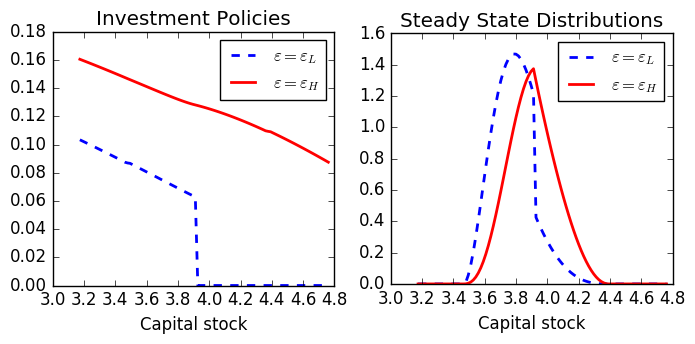

In [33]:
using PyPlot

fig, axes = subplots(1,2)
ax = axes[1]
ax[:plot](eg.k, eg_ss.investment[:,1], "b--", lw = 2, label = L"\varepsilon = \varepsilon_L")
ax[:plot](eg.k, eg_ss.investment[:,2], "r-", lw = 2, label = L"\varepsilon = \varepsilon_H")
ax[:legend](ncol = 1, fontsize = 12)
ax[:set_xlabel]("Capital stock")
ax[:set_title]("Investment Policies")
ax[:set_aspect](9)

ax = axes[2]
ax[:plot](eg.k, eg_ss.g[:,1], "b--", lw = 2, label = L"\varepsilon = \varepsilon_L")
ax[:plot](eg.k, eg_ss.g[:,2], "r-", lw = 2, label = L"\varepsilon = \varepsilon_H")
ax[:legend](ncol = 1, fontsize = 12)
ax[:set_xlabel]("Capital stock")
ax[:set_ylim]([0, 1.6])
ax[:set_title]("Steady State Distributions")
ax[:set_aspect]("equal")

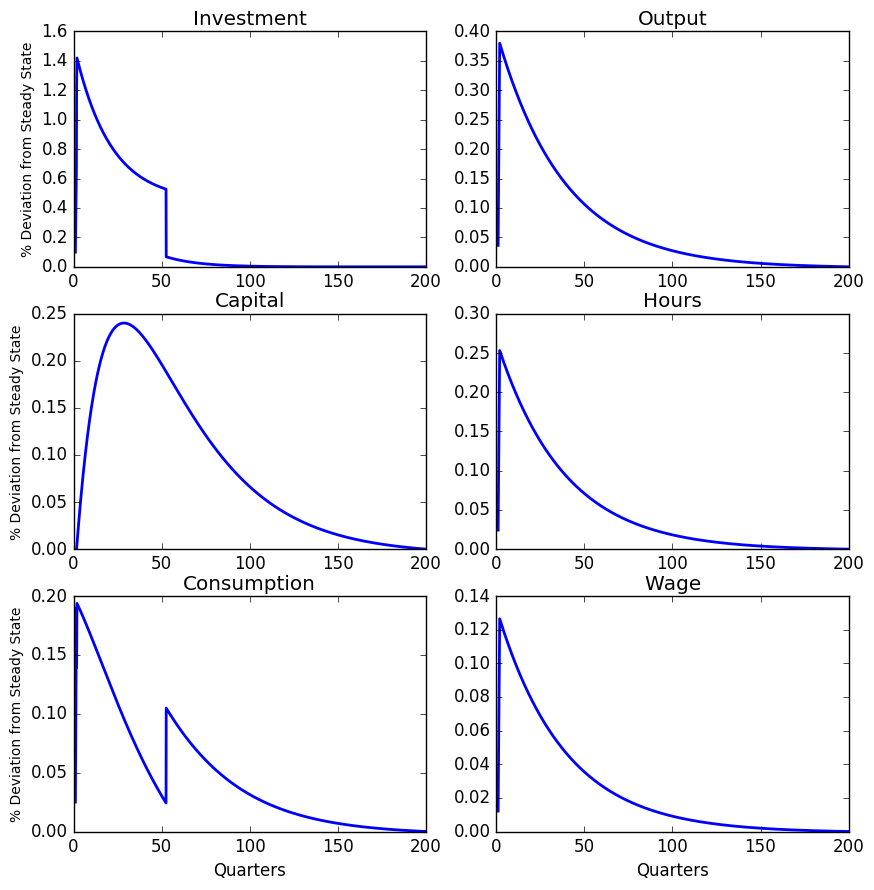

PyObject <matplotlib.text.Text object at 0x327199bd0>

In [34]:
# compute some impulse responses

inv_irf = zeros(N,1)
cap_irf = zeros(N,1)
cons_irf = zeros(N,1)
out_irf = zeros(N,1)
hrs_irf = zeros(N,1)
wage_irf = zeros(N,1)

for n = 1:N
    inv_irf[n] = 100*(agg_series[n].Investment - agg_series[N].Investment)/agg_series[N].Investment
    cap_irf[n] = 100*(agg_series[n].Capital - agg_series[N].Capital)/agg_series[N].Capital
    cons_irf[n] = 100*(agg_series[n].Consumption - agg_series[N].Consumption)/agg_series[N].Consumption
    out_irf[n] = 100*(agg_series[n].Output - agg_series[N].Output)/agg_series[N].Output
    hrs_irf[n] = 100*(agg_series[n].Hours - agg_series[N].Hours)/agg_series[N].Hours
    wage_irf[n] = 100*(agg_series[n].Wage - agg_series[N].Wage)/agg_series[N].Wage
end

t = linspace(1, T, N)

fig, axes = subplots(3,2, figsize = (10,10))
ax = axes[1]
ax[:plot](t, inv_irf, "b-", lw = 2)
ax[:set_title]("Investment")
ax[:set_ylabel]("% Deviation from Steady State", fontsize = 10)
ax[:set_ylim]([0, 1.6])

ax = axes[2]
ax[:plot](t, cap_irf, "b-", lw = 2)
ax[:set_title]("Capital")
ax[:set_ylabel]("% Deviation from Steady State", fontsize = 10)
ax[:set_ylim]([0, 0.25])

ax = axes[3]
ax[:plot](t, cons_irf, "b-", lw = 2)
ax[:set_title]("Consumption")
ax[:set_xlabel]("Quarters")
ax[:set_ylabel]("% Deviation from Steady State", fontsize = 10)

ax = axes[4]
ax[:plot](t, out_irf, "b-", lw = 2)
ax[:set_title]("Output")

ax = axes[5]
ax[:plot](t, hrs_irf, "b-", lw = 2)
ax[:set_title]("Hours")

ax = axes[6]
ax[:plot](t, wage_irf, "b-", lw = 2)
ax[:set_xlabel]("Quarters")
ax[:set_title]("Wage")